[Reference](https://medium.com/@tejpal.abhyuday/converting-tabular-dataset-csv-file-to-graph-dataset-with-pytorch-geometric-b3aea6b64100)

In [1]:
import pandas as pd

# Download data (quietly)
!wget -q https://raw.githubusercontent.com/batuhan-demirci/fifa21_dataset/master/data/tbl_player.csv
!wget -q https://raw.githubusercontent.com/batuhan-demirci/fifa21_dataset/master/data/tbl_player_skill.csv
!wget -q https://raw.githubusercontent.com/batuhan-demirci/fifa21_dataset/master/data/tbl_team.csv

# Load data
player_df = pd.read_csv("tbl_player.csv")
skill_df = pd.read_csv("tbl_player_skill.csv")
team_df = pd.read_csv("tbl_team.csv")

# Extract subsets
player_df = player_df[["int_player_id", "str_player_name", "str_positions", "int_overall_rating", "int_team_id"]]
skill_df = skill_df[["int_player_id", "int_long_passing", "int_ball_control", "int_dribbling"]]
team_df = team_df[["int_team_id", "str_team_name", "int_overall"]]

# Merge data
player_df = player_df.merge(skill_df, on='int_player_id')
fifa_df = player_df.merge(team_df, on='int_team_id')

# Sort dataframe
fifa_df = fifa_df.sort_values(by="int_overall_rating", ascending=False)
print("Players: ", fifa_df.shape[0])
fifa_df.head()

Players:  18767


,int_player_id,str_player_name,str_positions,int_overall_rating,int_team_id,int_long_passing,int_ball_control,int_dribbling,str_team_name,int_overall
0,1,Lionel Andrés Messi Cuccittini,"RW, ST, CF",93,5.0,91,96,96,FC Barcelona,84
33,2,Cristiano Ronaldo dos Santos Aveiro,"ST, LW",92,6.0,77,92,88,Juventus,83
57,3,Jan Oblak,GK,91,8.0,40,30,12,Atlético Madrid,83
121,5,Neymar da Silva Santos Júnior,"LW, CAM",91,7.0,81,95,95,Paris Saint-Germain,83
89,4,Kevin De Bruyne,"CAM, CM",91,2.0,93,92,88,Manchester City,85


In [2]:
# Make sure that we have no duplicate nodes
max(fifa_df["int_player_id"].value_counts())

1

In [3]:
# Sort to define the order of nodes
sorted_df = fifa_df.sort_values(by="int_player_id")
# Select node features
node_features = sorted_df[["str_positions", "int_long_passing", "int_ball_control", "int_dribbling"]]
# Convert non-numeric columns
pd.set_option('mode.chained_assignment', None)
positions = node_features["str_positions"].str.split(",", expand=True)
node_features["first_position"] = positions[0]
# One-hot encoding
node_features = pd.concat([node_features, pd.get_dummies(node_features["first_position"])], axis=1, join='inner')
node_features.drop(["str_positions", "first_position"], axis=1, inplace=True)
node_features.head()

,int_long_passing,int_ball_control,int_dribbling,CAM,CB,CDM,CF,CM,GK,LB,LM,LW,LWB,RB,RM,RW,RWB,ST
0,91,96,96,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
33,77,92,88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
57,40,30,12,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
89,93,92,88,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
121,81,95,95,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [4]:
# Convert to numpy
x = node_features.to_numpy()
x.shape # [num_nodes x num_features]

(18767, 18)

In [5]:
# Sort to define the order of nodes
sorted_df = fifa_df.sort_values(by="int_player_id")
# Select node features
labels = sorted_df[["int_overall"]]
labels.head()

,int_overall
0,84
33,83
57,83
89,85
121,83


In [6]:
# Remap player IDs
fifa_df["int_player_id"] = fifa_df.reset_index().index
# This tells us how many players per team we have to connect
fifa_df["str_team_name"].value_counts()

Everton                   36
Valencia CF               34
FC Nantes                 34
Villarreal CF             34
Real Valladolid CF        34
                          ..
Wellington Phoenix        19
Central Coast Mariners    19
Melbourne Victory         19
Brisbane Roar             19
Adelaide United           19
Name: str_team_name, Length: 681, dtype: int64

In [7]:
import itertools
import numpy as np

teams = fifa_df["str_team_name"].unique()
all_edges = np.array([], dtype=np.int32).reshape((0, 2))
for team in teams:
    team_df = fifa_df[fifa_df["str_team_name"] == team]
    players = team_df["int_player_id"].values
    # Build all combinations, as all players are connected
    permutations = list(itertools.combinations(players, 2))
    edges_source = [e[0] for e in permutations]
    edges_target = [e[1] for e in permutations]
    team_edges = np.column_stack([edges_source, edges_target])
    all_edges = np.vstack([all_edges, team_edges])
# Convert to Pytorch Geometric format
edge_index = all_edges.transpose()
edge_index # [2, num_edges]

array([[    0,     0,     0, ..., 18704, 18704, 18719],
       [    7,    32,    45, ..., 18719, 18751, 18751]])

In [8]:
import torch
e = torch.tensor(edge_index, dtype=torch.long)
print(e)

edge_index1 = e.t().clone().detach()
edge_index1

tensor([[    0,     0,     0,  ..., 18704, 18704, 18719],
        [    7,    32,    45,  ..., 18719, 18751, 18751]])


tensor([[    0,     7],
        [    0,    32],
        [    0,    45],
        ...,
        [18704, 18719],
        [18704, 18751],
        [18719, 18751]])

In [9]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 10.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=5f145e53cb320f9eb814e5b4018d1c1bf7d550fc851e59ed406b0b2dbecc0478
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


In [10]:
# from torch_geometric.data import Data
# data = Data(x=x, edge_index=edge_index1.to().contiguous(), y=y)

In [11]:
# from torch_geometric.data import Data
# data = Data(x=x, edge_index=edge_index1.t().contiguous(), y=y)

# from torch_geometric.data import Data
# from torch_geometric.utils import to_networkx
# networkX_graph = to_networkx(data)

In [12]:
# import networkx as nx
# nx.draw(networkX_graph)

In [13]:
import pandas as pd

# Download data (quietly)
!wget -q https://raw.githubusercontent.com/Mayank-Bhatia/Anime-Recommender/master/data/anime.csv
!wget -q https://raw.githubusercontent.com/Mayank-Bhatia/Anime-Recommender/master/data/rating.csv

anime = pd.read_csv("anime.csv")
rating = pd.read_csv("rating.csv")

In [14]:
# Sort to define the order of nodes
sorted_df = anime.sort_values(by="anime_id").set_index("anime_id")

# Map IDs to start from 0
sorted_df = sorted_df.reset_index(drop=False)
movie_id_mapping = sorted_df["anime_id"]

# Select node features
node_features = sorted_df[["type", "genre", "episodes"]]
# Convert non-numeric columns
pd.set_option('mode.chained_assignment', None)

# For simplicity I'll just select the first genre here and ignore the others
genres = node_features["genre"].str.split(",", expand=True)
node_features["main_genre"] = genres[0]

# One-hot encoding
anime_node_features = pd.concat([node_features, pd.get_dummies(node_features["main_genre"])], axis=1, join='inner')
anime_node_features = pd.concat([anime_node_features, pd.get_dummies(anime_node_features["type"])], axis=1, join='inner')
anime_node_features.drop(["genre", "main_genre"], axis=1, inplace=True)
anime_node_features.head(10)

,type,episodes,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,...,Supernatural,Thriller,Vampire,Yaoi,Movie,Music,ONA,OVA,Special,TV
0,TV,26,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,Movie,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,TV,26,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,TV,26,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,TV,52,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,TV,145,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,TV,24,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,TV,52,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,TV,24,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,TV,74,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [15]:
# Convert to numpy
x = anime_node_features.to_numpy()
x.shape # [num_movie_nodes x movie_node_feature_dim]

(12294, 48)

In [16]:
# Find out mean rating and number of ratings per user
mean_rating = rating.groupby("user_id")["rating"].mean().rename("mean")
num_rating = rating.groupby("user_id")["rating"].count().rename("count")
user_node_features = pd.concat([mean_rating, num_rating], axis=1)

# Remap user ID (to start at 0)
user_node_features = user_node_features.reset_index(drop=False)
user_id_mapping = user_node_features["user_id"]

# Only keep features
user_node_features = user_node_features[["mean", "count"]]
user_node_features.head()

,mean,count
0,-0.712418,153
1,2.666667,3
2,7.382979,94
3,-1.000000,52
4,4.263383,467


In [17]:
# Convert to numpy
x = user_node_features.to_numpy()
x.shape # [num_user_nodes x user_node_feature_dim]

(73515, 2)

In [18]:
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


<Axes: >

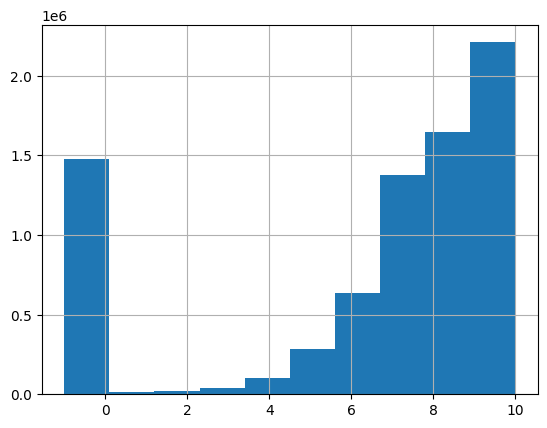

In [19]:
#-1 means the user watched but didn't assign a weight
rating["rating"].hist()

In [21]:
# Movies that are part of our rating matrix
rating["anime_id"].unique()


# All movie IDs (e.g. no rating above for 1, 5, 6...)
anime["anime_id"].sort_values().unique()

# We can also see that there are some movies in the rating matrix, for which we have no features (we will drop them here)
print(set(rating["anime_id"].unique()) - set(anime["anime_id"].unique()))
rating = rating[~rating["anime_id"].isin([30913, 30924, 20261])]

{30913, 30924, 20261}


In [22]:
# Extract labels
labels = rating["rating"]
labels.tail()

7813732     7
7813733     9
7813734    10
7813735     9
7813736     9
Name: rating, dtype: int64

In [23]:
# Convert to numpy
y = labels.to_numpy()
y.shape

(7813727,)

In [24]:
# Map anime IDs
movie_map = movie_id_mapping.reset_index().set_index("anime_id").to_dict()
rating["anime_id"] = rating["anime_id"].map(movie_map["index"]).astype(int)
# Map user IDs
user_map = user_id_mapping.reset_index().set_index("user_id").to_dict()
rating["user_id"] = rating["user_id"].map(user_map["index"]).astype(int)

print("After remapping...")
rating.head()

After remapping...


,user_id,anime_id,rating
0,0,10,-1
1,0,14,-1
2,0,58,-1
3,0,202,-1
4,0,217,-1


In [25]:
edge_index = rating[["user_id", "anime_id"]].values.transpose()
edge_index # [2 x num_edges]

array([[    0,     0,     0, ..., 73513, 73514, 73514],
       [   10,    14,    58, ...,  8624,   718,  5226]])

In [26]:
from torch_geometric.data import HeteroData
data = HeteroData()
data['user'].x = user_node_features
data['movie'].x = anime_node_features

In [27]:
data['user', 'rating', 'movie'].edge_index = edge_index

In [28]:
data['user', 'movie'].y = y